In [1]:
#|echo: false

##---- Load all necessary libraries ----##

# math, df, os, misc.
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import scipy.io
from scipy import stats
from PIL import Image
import os

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import networkx as nx
import seaborn as sns

# algorithms
import scipy.sparse.linalg as ll
from sklearn.decomposition import PCA
from scipy.sparse.csgraph import shortest_path


# 1 - Conceptual questions

## Question 1.1

The first principle component direction $v$ corresponds to the largest eigenvector of the sample covariance matrix:
$$
v = \arg\max_{w: \|w\|\leq 1} \frac 1 m \sum_{i=1}^m (w^T x^i - w^T \mu)^2.
$$


**Proof using steps from Module 4 - PCA Dimensionality Reduction lecture:**

Given $m$ data points $\{x^1, x^2, \ldots, x^m\} \in \mathbb R^{n}$, we want to find the direction $w$ that maximizes the variance of the data projected onto $w$. 

The mean of the data can be defined as:
$$ \mu = \frac{1}{m} \sum_{i=1}^m x^i $$

The variance of the data projected onto $w$ is:
$$ \text{Var} = \frac{1}{m} \sum_{i=1}^m (w^T x^i - w^T \mu)^2 =\frac{1}{m} \sum_{i=1}^m (w^T (x^i - \mu))^2 $$
where the goal is to maximize the equation above subject to $\|w\| \leq 1$.

Simplifying the terms further:
$$ \frac{1}{m} \sum_{i=1}^m w^T(x^i - \mu) (x^i - \mu)^T w $$

The sample covariance matrix $C$ can be defined as:
$$ C = \frac{1}{m} \sum_{i=1}^m (x^i - \mu)(x^i - \mu)^T $$

This gives the following objective function:
$$ \frac{1}{m} \sum_{i=1}^m w^T(x^i - \mu) (x^i - \mu)^T w = w^T C w $$
$$ \max_{w: \|w\|\leq 1} w^T C w $$

To solve the constrained optimization problem, I can use the method of Lagrange multipliers. 
The Lagrangian can be defined as:
$$ L(w, \lambda) = w^T C w + \lambda (1 - \|w\|^2) $$

If $w$ is a maximum of the original optimization problem, then there must exist a $\lambda$ where $(w, \lambda)$ is a stationary point of $L(w, \lambda)$. 

By taking the partial derivative of the Lagrangian with respect to $w$ and setting it to zero, we can see that:
$$ \frac{\partial L}{\partial w} = 0 = 2Cw - 2\lambda w = 0 \implies Cw = \lambda w $$

This shows that the optimal solution $w$ must be an eigenvector of $C$. Since the objective function becomes $\lambda$ that is associated with $w$, $w$ should be the eigenvector corresponding to the largest eigenvalue $\lambda_1$ in order to maximize $w^T C w$.

Therefore, the direction $v$ that maximizes the variance of the projected data is the eigenvector of the covariance matrix $C$ corresponding to the largest eigenvalue. This eigenvector is the first principal component direction.

## Question 1.2

Based on the outline given in the lecture, it can be show that the maximum likelihood estimate (MLE) for Gaussian random variable using observations $x^1, \ldots, x^m$, that are *i.i.d.* (independent and identically distributed) following the distribution $\mathcal N(\mu, \sigma^2)$, and the mean and variance parameters are given by 
$$
\hat \mu = \frac 1 m \sum_{i=1}^m x^i,\quad \hat \sigma^2 = \frac 1 m \sum_{i=1}^m (x^i - \hat \mu)^2,
$$
respectively. 

**Proof using online sources ([StatLect](https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood), [StatQuest YouTube](https://www.youtube.com/watch?v=Dn6b9fCIUpM), & [Mike the Mathematician YouTube](https://www.youtube.com/watch?v=EkTZlxY02o4)) and the outline given in the lectures:**

The probability density function of a Gaussian random variable $x$ with mean $\mu$ and variance $\sigma^2$ is:

$$ f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(x - \mu)^2}{2 \sigma^2} \right) $$

Given $m$ i.i.d. observations $x^1, x^2, \ldots, x^m$, the likelihood function $L(\mu, \sigma^2)$ is the product of the individual densities:
$$ L(\mu, \sigma^2) = \prod_{i=1}^m f(x^i| \mu, \sigma^2) = \prod_{i=1}^m \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(x^i - \mu)^2}{2 \sigma^2} \right) $$

To simplify calculations, I can take the natural logarithm of the likelihood function, giving me the log-likelihood function $\ell(\mu, \sigma^2)$:
$$ \ell(\mu, \sigma^2) = \ln L(\mu, \sigma^2) = \sum_{i=1}^m \ln \left( \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(x^i - \mu)^2}{2 \sigma^2} \right) \right) $$
$$ \ell(\mu, \sigma^2) = \sum_{i=1}^m \left( -\frac{1}{2} \ln(2 \pi \sigma^2) - \frac{(x^i - \mu)^2}{2 \sigma^2} \right) $$

$$ \ell(\mu, \sigma^2) = -\frac{m}{2} \ln(2 \pi \sigma^2) - \frac{1}{2 \sigma^2} \sum_{i=1}^m (x^i - \mu)^2 $$

To find the values of $\mu$ and $\sigma^2$ that maximize $\ell(\mu, \sigma^2)$, I can take the partial derivatives with respect to $\mu$ and $\sigma^2$, set them to zero, and solve for the parameters.

The partial derivative of $\ell(\mu, \sigma^2)$ with respect to $\mu$:
$$ \frac{\partial \ell(\mu, \sigma^2)}{\partial \mu} = - \frac{1}{2 \sigma^2} \frac{\partial}{\partial \mu} \sum_{i=1}^m (x^i - \mu)^2 $$
$$ \frac{\partial}{\partial \mu} \sum_{i=1}^m (x^i - \mu)^2 = \sum_{i=1}^m 2(x^i - \mu)(-1) = -2 \sum_{i=1}^m (x^i - \mu) $$
$$ \frac{\partial \ell(\mu, \sigma^2)}{\partial \mu} = \frac{1}{\sigma^2} \sum_{i=1}^m (x^i - \mu) $$

Setting the derivative to zero and solving for $\mu$:
$$ \frac{1}{\sigma^2} \sum_{i=1}^m (x^i - \mu) = 0 $$
$$ \sum_{i=1}^m x^i - m \mu = 0 $$
$$ \mu = \frac{1}{m} \sum_{i=1}^m x^i = \hat{\mu} $$

Next, I can compute the partial derivative of $\ell(\mu, \sigma^2)$ with respect to $\sigma^2$:
$$ \frac{\partial \ell(\mu, \sigma^2)}{\partial \sigma^2} = -\frac{m}{2} \frac{1}{\sigma^2} + \frac{1}{2 (\sigma^2)^2} \sum_{i=1}^m (x^i - \mu)^2 $$

Setting the derivative to zero:
$$ -\frac{m}{2 \sigma^2} + \frac{1}{2 (\sigma^2)^2} \sum_{i=1}^m (x^i - \mu)^2 = 0 $$

Multiplying both sides by $2 (\sigma^2)^2$:
$$ -m \sigma^2 + \sum_{i=1}^m (x^i - \mu)^2 = 0 $$

Solving for $\sigma^2$:
$$ m \sigma^2 = \sum_{i=1}^m (x^i - \mu)^2 $$
$$ \sigma^2 = \frac{1}{m} \sum_{i=1}^m (x^i - \mu)^2 = \hat{\sigma}^2 $$

Therefore, the maximum likelihood estimates for the parameters of the Gaussian distribution are:
$$ \hat{\mu} = \frac{1}{m} \sum_{i=1}^m x^i, \quad \hat{\sigma}^2 = \frac{1}{m} \sum_{i=1}^m (x^i - \hat{\mu})^2 $$

These results match the expressions for the sample mean and sample variance.

## Question 1.3

The ISOMAP (Isometric Mapping) algorithm, a method for manifold learning and nonlinear dimensionality reduction, is built on three key ideas:

1. ISOMAP starts by constructing a neighborhood graph to capture the local geometry of the data. This involves determining which points are neighbors on the manifold. Two common methods are connecting each point to all points within a fixed radius $\epsilon$ and connecting each point to its $K$ nearest neighbors. These neighborhood relations are represented in an adjacency matrix $A$ with entries recording the Euclidean distances between neighboring points.

2. ISOMAP estimates the geodesic distances between all pairs of points on the manifold. This is done by computing the shortest path distances based on the adjacency matrix $A$. The geodesic distance between two points is approximated by the sum of the shortest paths connecting them through their neighbors which captures the intrinsic geometry of the manifold. These shortest paths can be computed using the Floyd-Warshall algorithm or Dijkstra's algorithm.

3. In the final step, ISOMAP applies Multidimensional Scaling (MDS) to the matrix of graph distances. This involves finding a low-dimensional embedding of the data that best preserves the manifold’s intrinsic geometry. The goal is to place the data points in a low-dimensional space such that the pairwise distances in this space approximate the geodesic distances on the manifold. This is done by minimizing a cost function through eigendecomposition.

## Question 1.4

There are several ways to decide $k$, the number of principle components, from data that ensure an appropriate balance between capturing significant data structure and avoiding overfitting.

1. The total variance in the data can be calculated and PCA can be performed to determine the principal components. Then, a plot of the explained variance for each principal component can be made and a $k$ can be chosen such that the cumulative variance explained by the first $k$ components meets a desired threshold, typically between 85-95%. This is the same as calculating the explained variance ratio for each principal component which represents the proportion of the total variance in the data explained by each principal component.

2. A scree plot of the eigenvalues (variances) of the principal components in descending order can be made. We can find the optimal $k$ by identify the "elbow point" where the rate of decrease in variance sharply slows down. The components before this point capture most of the variance in the data.

3. Another method is using cross-validation techniques where the data is split into training and validation sets. PCA can then be performed on the training set and both sets can be projected onto the first $k$ principal components. The reconstruction error or classification performance can be evaluated as a function of $k$. We would choose the $k$ that minimizes error or maximizes performance.

## Question 1.5

Outliers can significantly impact the performance of PCA because PCA is sensitive to the variance in the data. PCA aims to find the directions that maximize the variance in the data. Outliers increase the overall variance and can cause PCA to align the principal components towards the outliers instead of the main data distribution. This misalignment can reduce the effectiveness of PCA in capturing the true structure of the data which leads to suboptimal dimensionality reduction and reconstruction.

An easy way to see this is through an example of PCA on randomly generated data.

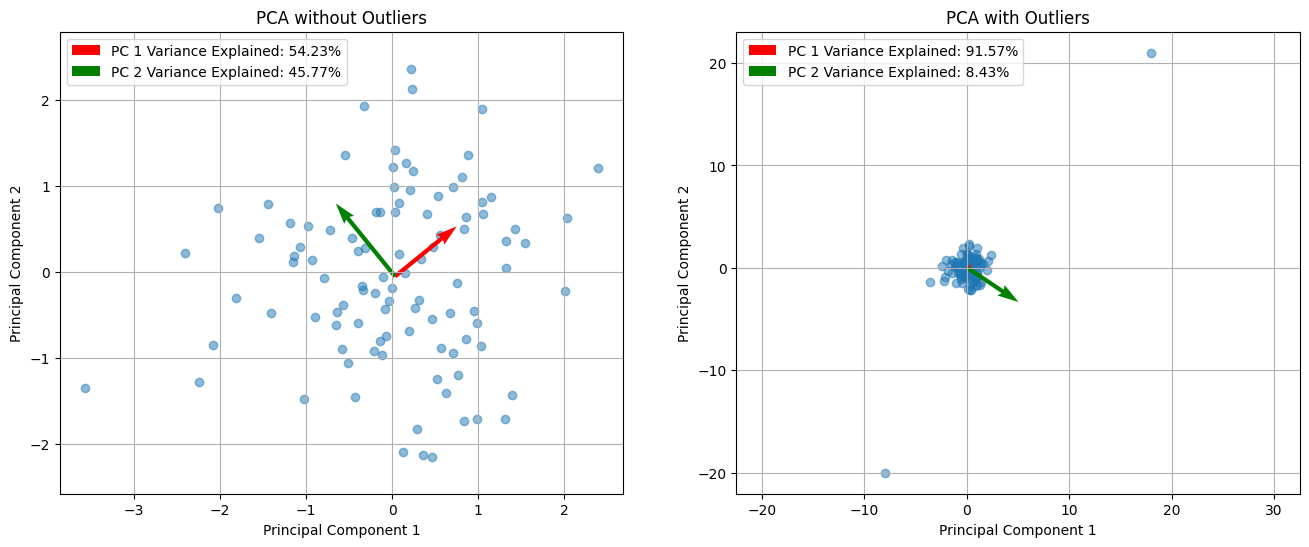

In [2]:
#| echo: false

def plot_pca(ax, xy, title):
    pca = PCA(n_components=2)
    pca.fit(xy)

    components = pca.components_
    explained_variance = pca.explained_variance_ratio_
    
    ax.scatter(xy[:, 0], xy[:, 1], alpha = 0.5)

    for i, (component, variance) in enumerate(zip(components, explained_variance)):
        ax.quiver(
            pca.mean_[0], pca.mean_[1], #arrow locations
            component[0], component[1], #arrow directions
            scale = 2 * variance, scale_units = 'xy', #scale so easier to see
            color = ['r', 'g'][i],
            label = f'PC {i+1} Variance Explained: {(variance*100):.2f}%') 

    # print(f'Explained Variance Ratios:\nPC 1 = {round(pca.explained_variance_ratio_[0], 4)}, PC 2 = {round(pca.explained_variance_ratio_[1], 4)}')

    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.axis('equal')
    ax.grid(True)
    ax.legend()

np.random.seed(1234)

# create data
x = np.random.normal(0, 1, 100)
y = np.random.normal(0, 1, 100)
xy = np.array([x,y]).T

# add outliers
outliers = np.array([[18, 21], [-8, -20]])
xy_with_outliers = np.vstack([xy, outliers])

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

plot_pca(axs[0], xy, 'PCA without Outliers')
plot_pca(axs[1], xy_with_outliers, 'PCA with Outliers')

As seen from the plots above, the presence of outliers has a significant impact on the PCA results. In the first plot without outliers, the explained variance ratio is much more balanced, with the first two principal components explaining roughly equal amounts of the variance in the data. However, in the plot with the outliers, the first principal component is heavily influenced by the outliers and the explained variance ratio is skewed. Here, the first principal component explains 91.57% of the variance, while the second component only explains 8.43% of the variance. This shows how outliers can significantly distort the PCA results.

# 2 - PCA: Food consumption in European countries

The data `food-consumption.csv` contains 16 countries in Europe and their consumption for 20 food items, such as tea, jam, coffee, yogurt, and others. I will perform principal component analysis to explore the data. In this question, PCA will be implemented from scratch. The full code can be found in the zip file attached with this assignment.

## 2.A

First, PCA analysis will be performed on the data by treating each country's food consumption as their "feature" vectors. The goal is to find the weight vectors to combine the 20 food-item consumptions for each country. The data matrix will be set up in a way that each row represents a country and each column represents a type of food. For each row, or each country, there will be a value corresponding to the food consumption for each type of food. 

The PCA code was developed using demo code from the lectures and can be found in the attached zip file. 

In [3]:
#| echo: false

# read in data
food_df = read_csv('data/food-consumption.csv')

features = food_df.drop('Country', axis = 1)
features_arr = features.to_numpy().astype(float)

countries = food_df['Country'] # country labels
foods = food_df.columns[1:] # food labels

In [4]:
#| echo: false

# Most of the code is from the demo code provided in the pca lecture
def perform_pca(data):
    # extract attributes from raw data
    Anew = data
    m,n = Anew.shape
    # print(m,n)

    ## Not going to standardize since feature ranges look fine
    
    # In this case, we normalize the data because features have very different ranges
    # stdA = np.std(Anew, axis = 0)
    # Anew = Anew @ np.diag(np.ones(stdA.shape[0])/stdA)
    Anew = Anew.T

    # PCA
    mu = np.mean(Anew,axis = 1)
    xc = Anew - mu[:,None]
    C = np.dot(xc,xc.T)/m
    K = 2
    S,W = ll.eigs(C,k = K)
    S = S.real
    W = W.real

    dim1 = np.dot(W[:,0].T,xc)/math.sqrt(S[0]) # extract 1st eigenvalues
    dim2 = np.dot(W[:,1].T,xc)/math.sqrt(S[1]) # extract 2nd eigenvalue

    return dim1, dim2

def plot_scatter(dim1, dim2, labels, title):
    pca_comps = np.array(list(zip(dim1, dim2)))

    pca_df = pd.DataFrame(data = pca_comps, columns = ['PC1', 'PC2'])
    pca_df['labels'] = labels

    plt.figure(figsize = (8,6))

    for i, label in enumerate(pca_df['labels']):
        plt.scatter(pca_df.loc[i, 'PC1'], pca_df.loc[i, 'PC2'])
        plt.text(pca_df.loc[i, 'PC1'] + 0.04, pca_df.loc[i, 'PC2'] + 0.04, label, fontsize = 9)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.grid(True, alpha = 0.3)

    plt.show()


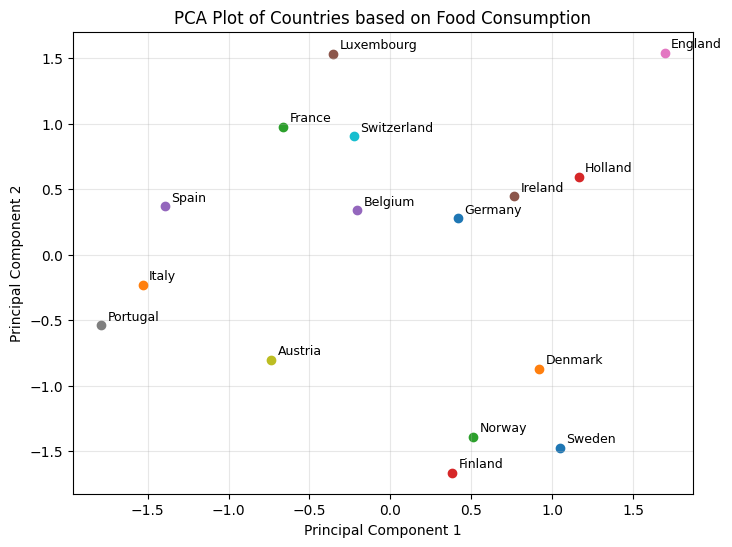

In [5]:
#| echo: false

dim1, dim2 = perform_pca(features_arr)
plot_scatter(dim1, dim2, countries, 'PCA Plot of Countries based on Food Consumption')

There are several interesting patterns when observing the plots above. There are many clusters that have formed where some countries are grouped together. Some countries that are geographically closer together are clustered together on the scatter plot, like Denmark, Norway, Sweden, and Finland, otherwise known as Scandinavia or the Nordic Countries. In the context of food consumption by country, this makes sense since their geographical location and cultural overlap might mean that they have similar eating habits. Another clustered group is Spain, Italy, and Portugal, who are also close together on the map and are countries associated with the Mediterranean diet. There are some countries with positive values (e.g., Luxembourg, England) and other countries with negative values (e.g., Finland, Sweden, Norway) which suggests that there are opposing patterns of food consumption among the countries. England seems to be an outlier, indicating that their food consumption patterns are different than the rest of the European countries. 

## 2.B

Now, PCA analysis will be performed on the data by treating country consumptions as "feature" vectors for each food item. In other words, the goal is to find the weight vectors to combine country consumptions for each food item to perform PCA another way. 

The PCA code was reran with the feature vectors transposed and the data labels adjusted to show food items. The code can be found in the attached zip file. 

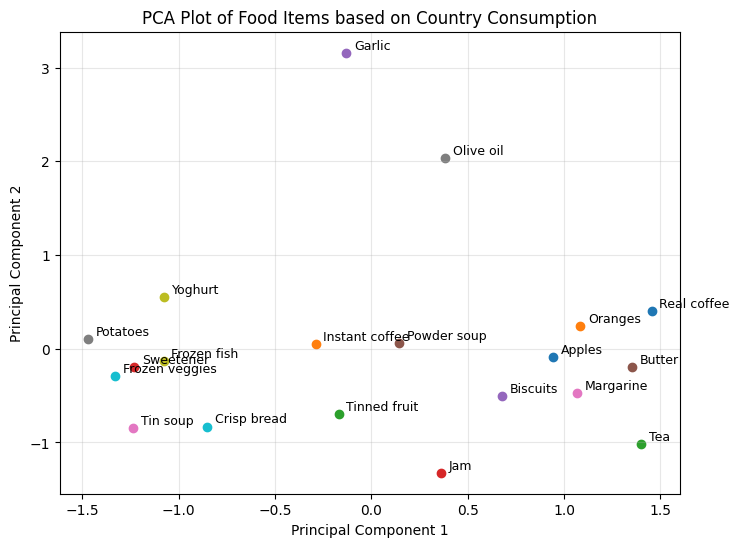

In [6]:
#| echo: false

dim1, dim2 = perform_pca(features_arr.T)
plot_scatter(dim1, dim2, foods, 'PCA Plot of Food Items based on Country Consumption')

The PCA plot above shows a clear clustering and distribution of food items along the principal components. For example, fruits are grouped together (e.g. apples, oranges, margarine) far away from some frozen foods (e.g. frozen fish, frozen veggies) on the first principal component. Some food items having positive values (e.g., garlic, olive oil) and others have negative values (e.g., tea, butter, jam), suggesting that there are opposing patterns of consumption for these food items across the countries. Some food items appear to be outliers, such as garlic, olive oil and jam, indicating they have very distinct consumption patterns compared to the other food items. This makes sense since these items cannot be consumed alone and often supplement other food items. There also seems to be a distinction between processed/packaged food items (e.g., tin soup, frozen veggies, yoghurt) and fresh/natural food items (e.g., apples, oranges, tea) along the first principal component. Overall, the PCA results and the natural clustering of the food items makes sense. If a buyer prefers frozen foods such as frozen vegetables, they are likely to also purchase frozen fish. If they prefer fresh alternatives instead, they would buy items like apples and oranges, which are categorized separately and positioned further away.

# 3 - Order of faces using ISOMAP

This question aims to reproduce the ISOMAP algorithm results in the original paper for ISOMAP, J.B. Tenenbaum, V. de Silva, and J.C. Langford, Science 290 (2000) 2319-2323 that we have also seen in the lecture as an exercise.

The file `isomap.mat` (or `isomap.dat`) contains 698 images, corresponding to different poses of the same face. Each image is given as a 64 x 64 luminosity map, hence represented as a vector in $\mathbb R^{4096}$. This vector is stored as a row in the file (this is one of the datasets used in the original paper).

By using Euclidean distance (in this case, a distance in $\mathbb R^{4096}$) to construct the $\epsilon$-ISOMAP, I will tune the $\epsilon$ parameter to achieve the most reasonable performance. This is different from $K$-ISOMAP, where each node has exactly $K$ nearest neighbors.

In [7]:
#|echo: false

# load data
mat = scipy.io.loadmat('data/isomap.mat')

data = mat['images'].T

m, n = data.shape
A = np.zeros((m,m))

In [8]:
#|echo: false

def draw_adjacency(A, eps):
    G = nx.Graph()

    # add nodes and edges
    for i in range(m):
        G.add_node(i)
        for j in range(m):
            if A[i, j] != 0:
                G.add_edge(i, j, weight = A[i, j])

    # good seeds: 234, 645412
    spring_layout_seed = 645412
    pos = nx.spring_layout(G, seed = spring_layout_seed)
    fig = plt.figure(figsize = (12, 8))

    nx.draw(G, pos, with_labels = False, node_size = 25, edge_color = 'lightgray')

    img_seed = 234
    np.random.seed(img_seed)
    rand_images = np.random.choice(range(m), size = 50, replace=False)

    for node in rand_images:
        x = pos[node][0]
        y = pos[node][1]

        img = data[node,:].reshape(64, 64).T
        im = OffsetImage(img, cmap = 'gray_r', zoom = 0.4)
        ab = AnnotationBbox(im, (x, y), pad = 0.1)
        plt.gca().add_artist(ab)
        plt.title(f'Nearest Neighbor Graph of the Adjacency Matrix using NetworkX\nEpsilon = {eps} | Random Seed = {spring_layout_seed}')

    plt.show()

In [9]:
#|echo: false

def isomap(A, eps):
    
    ## Following steps from lecture 5 below

    # step 1: build a weighted graph A
    for i in range(m):
        for j in range(m):
            dist = np.linalg.norm([data[i]-data[j]])
            if dist <= eps:
                A[i,j] = dist

    # visualize the nearest neighbor graph
    # draw_adjacency(A)

    # step 2: compute pairwise shortest distance matrix D (D is mxm)
    # from scipy.sparse.csgraph import shortest_path
    D = shortest_path(A)

    # step 3: use a centering matrix H = I - (1/m) 11.T to get C = -(1/2) H D**2 H --> (mxm matrix)
    # m = 698 in this case
    H = np.identity(m) - (1/m) * np.outer(np.ones(m),np.ones(m).T)
    C = -(1/2) * H @ (D**2) @ H

    # step 4: compute leading eigenvectors w1,w2,... and eigenvalues lambda1, lambda2,... of C
    eigenvalues, eigenvectors = np.linalg.eig(C)
    S = eigenvalues.real
    W = eigenvectors.real
    dim1 = W[:,0]*np.sqrt(S[0]) # extract 1st eigenvalues
    dim2 = W[:,1]*np.sqrt(S[1]) # extract 2nd eigenvalue

    return dim1, dim2

def draw_isomap(dim1, dim2, eps):

    # step 5: visualize using scatter plot
    fig = plt.figure(figsize = (12, 9))

    plt.scatter(dim1, dim2)

    seed = 1219
    np.random.seed(seed)
    rand_images = np.random.choice(range(len(dim1)), size = 50, replace=False)

    for i in rand_images:
        img = data[i,:].reshape(64, 64).T
        
        # https://matplotlib.org/stable/gallery/text_labels_and_annotations/demo_annotation_box.html

        plt.gca().add_artist(plt.Circle((dim1[i], dim2[i]), 0.8, fill=False, color='r'))
        im = OffsetImage(img, cmap = 'gray_r', zoom = 0.5)
        ab = AnnotationBbox(im, xy=(dim1[i] + 3, dim2[i] + 3), pad = 0.1)
        plt.gca().add_artist(ab)
        plt.title(f'ISOMAP 2D Low-Dimensional Embedding Plot\nEpsilon = {eps} | Random Seed = {seed}')

    plt.show()

In [10]:
#|echo: false

# epsilons = list(range(1, 50))

# for eps in epsilons:
#     print(eps)
#     try:
#         isomap(A, eps)
#     except:
#         # means that eps was too small
#         print(f'{eps} failed due to inf/nan errors')
#         continue

# best eps: 13, 14, 15
eps = 13
dim1, dim2 = isomap(A, eps)


## 3.A

The `isomap.mat` data file was loaded in and an adjacency matrix was created. In order to create this adjacency matrix, I first had to code the ISOMAP algorithm from scratch and this code can be found in the attached zip file. The first step in ISOMAP is to build the weighted graph $A$ which is the adjacency matrix. This matrix is created if the euclidean distance between points $x^i$ and $x^j$ was less than or equal to a tuned $\epsilon$. After testing $\epsilon$ values from 1 to 50, I found that $\epsilon = 13$ worked the best in creating the Mickey Mouse shaped scatter plot. Therefore, this adjacency matrix was created with this fine tuned $\epsilon$. I used the python library package, NetworkX, to visualize the nearest neighbor graph and plotted a few images corresponding to random data points.

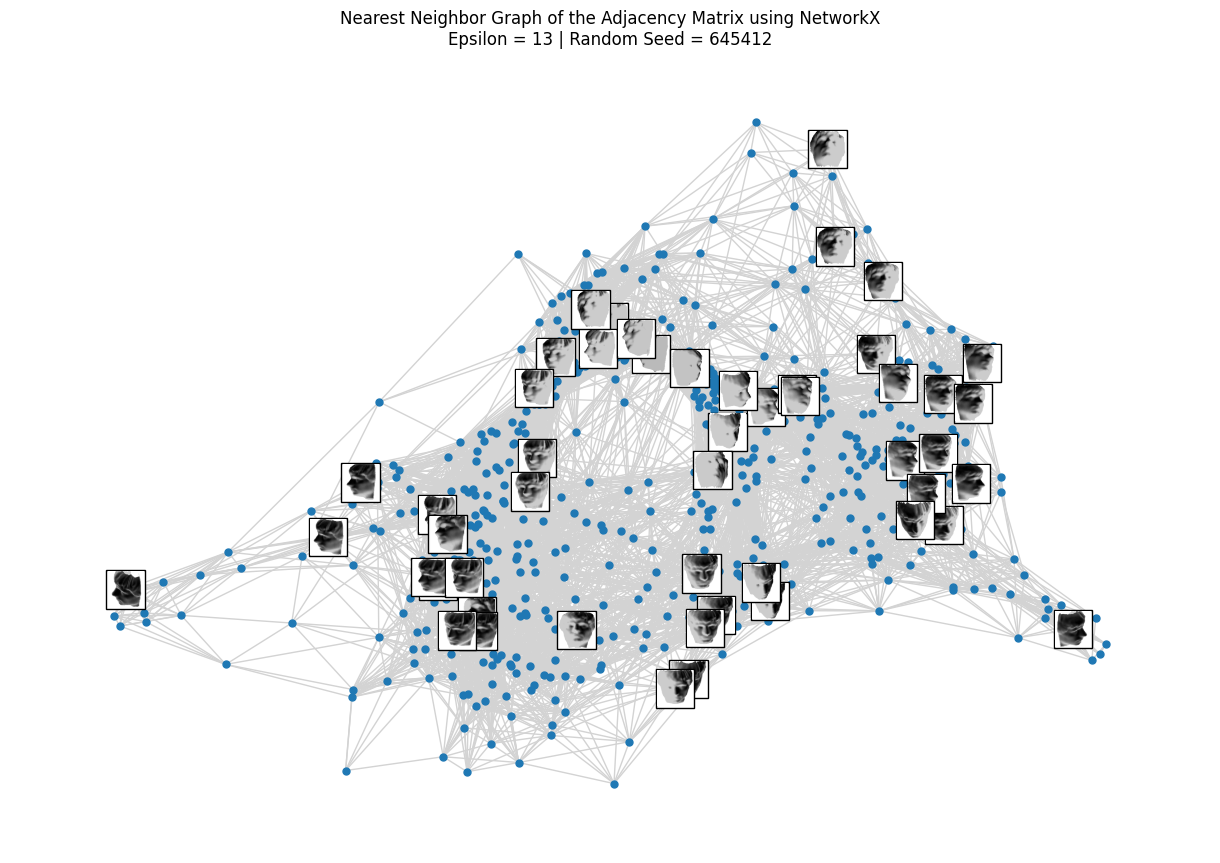

In [11]:
#| echo: false
draw_adjacency(A, eps)

# plt.imshow(A)
# plt.colorbar()
# plt.show()

The plot above shows the nearest neighbor graph of the adjacency matrix using NetworkX. This is a visualization of the relationships between data points with the blue dots representing the data points and the gray lines connecting the nearest neighbors. There seems to be naturally clustered images sharing similar characteristics and some distinct groups or communities that are more densely connected within themselves. For example, images on the far left seem to be of faces looking left and are not lit as well as the images in the direct center of the network. Images on the far right are of faces looking right and are also dark due to low lighting. The images grouped in the center bottom seem to be of faces looking straight ahead with even lighting. Overall, we can see some groupings of images after simply just creating the adjacency matrix.

## 3.B

I ran the ISOMAP algorithm to obtain a two-dimensional low-dimensional embedding of the data and plotted the results on a scatter plot with a few images annotated near some random points.

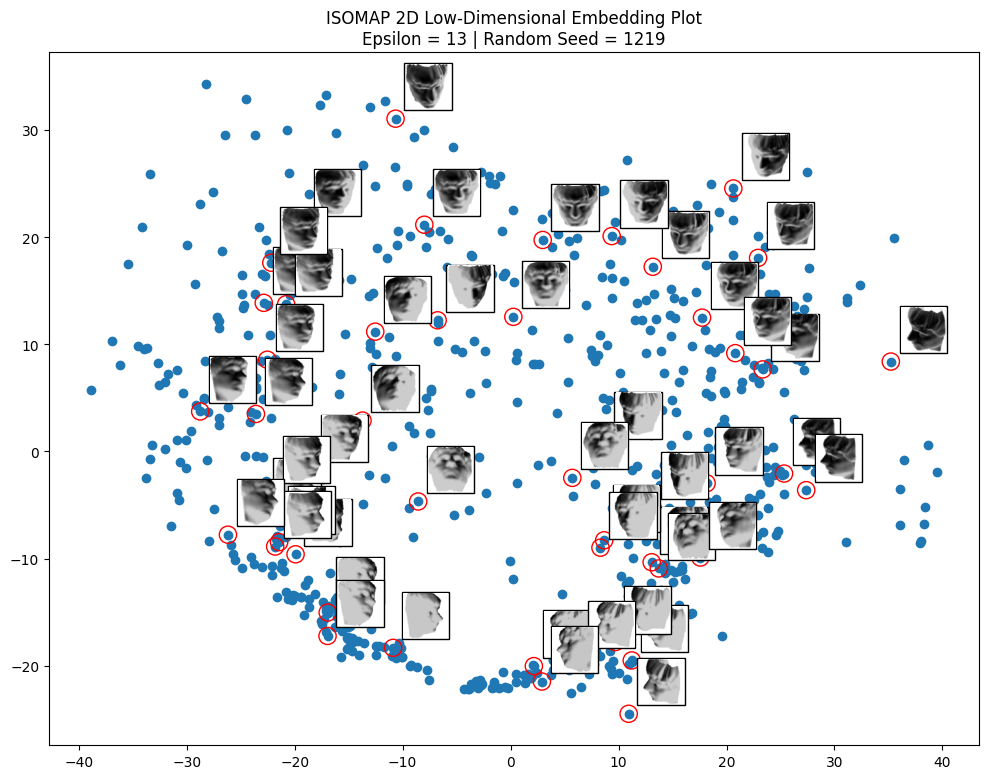

In [12]:
#|echo: false
draw_isomap(dim1, dim2, eps)

As seen from the plot above, the images are grouped in a similar way to the ISOMAP paper. Images on the top right are of faces looking towards the center of the plot (or faces looking bottom left), and seem to turn more left as you go around the plot in a clockwise direction. The images on the far right are of faces looking left while the images on the far left are of faces looking to the right. Images in the center are of faces looking straight ahead while images at the top seem to be of faces looking slightly down. 

There seems to be grouping based on how the lighting is on the faces as well. Generally, well-lit faces are in the center while darker faces with more shadows and less lighting are on the outside edges of the plot. The data points are not as cleanly spread out as the ISOMAP paper and the algorithm does not group the faces looking up as well as the published paper did. Overall, the expected Mickey Mouse face can be visually seen from the data points and the ISOMAP algorithm clearly depicts separation of the images based on image characteristics. 

## 3.C

Finally, I performed PCA on the images and projected them into the top 2 principal components. The scatter plot of the result is shown below.

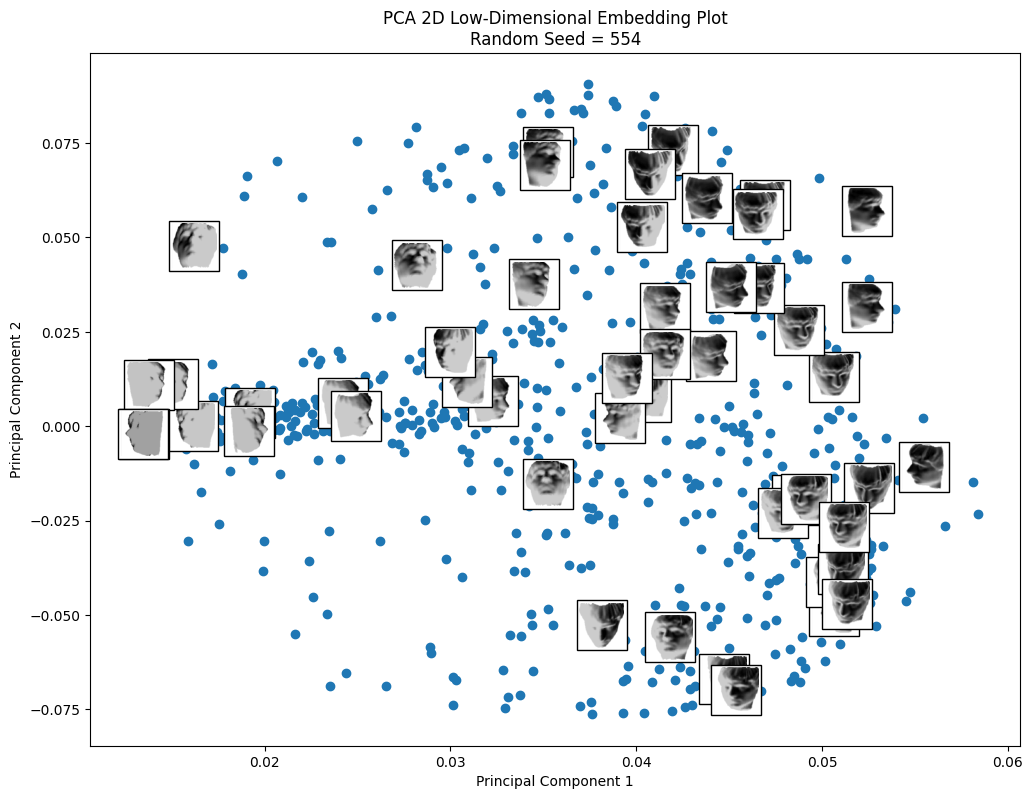

In [13]:
#|echo: false

pca = PCA(n_components=2)
pca.fit(data.T)
components = pca.components_    
dim_1 = components[0]
dim_2 = components[1]

fig = plt.figure(figsize = (12, 9))
plt.scatter(components[0], components[1])

# good seedS: 8744, 554
pca_img_seed = 554
np.random.seed(pca_img_seed)
rand_images = np.random.choice(range(len(dim_1)), size = 50, replace=False)

for i in rand_images:
    img = data[i,:].reshape(64, 64).T
    im = OffsetImage(img, cmap = 'gray_r', zoom = 0.5)
    ab = AnnotationBbox(im, xy = (dim_1[i], dim_2[i]), pad = 0.2)
    plt.gca().add_artist(ab)

plt.title(f'PCA 2D Low-Dimensional Embedding Plot\nRandom Seed = {pca_img_seed}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

The scatter plot shows similar groupings of images as the ISOMAP algorithm but it is visually harder to differentiate some changes. 
For instance, the bottom right section of the ISOMAP plot contains a cluster of faces looking down and to the left, while slightly above this cluster are faces looking down and to the right. The images on the far left are a mix of faces looking left and right, with the only similarity being that the faces are extremely lit and have many more white pixels than the faces on the far right who are not as well lit and have more shadows. 

It seems that the PCA algorithm is grouping images based more on the brightness levels at different parts of the image while the ISOMAP algorithm captures not just the brightness levels but the compositional and directional aspects of the facial images. Overall, the ISOMAP algorithm provided a more meaningful projection compared to the PCA implementation. 

# 4 - Density estimation: Psychological experiments

In *Kanai, R., Feilden, T., Firth, C. and Rees, G., 2011. Political orientations are correlated with brain structure in young adults. Current biology, 21(8), pp.677-680.*, data are collected to study whether or not the two brain regions are likely to be independent of each other and considering different types of political view. The data set `n90pol.csv` contains information on 90 university students who participated in a psychological experiment designed to look for relationships between the size of different regions of the brain and political views. The variables `amygdala` and `acc` indicate the volume of two particular brain regions known to be involved in emotions and decision-making, the amygdala and the anterior cingulate cortex; more exactly, these are residuals from the predicted volume, after adjusting for height, sex, and similar body-type variables. The variable `orientation` gives the students' locations on a five-point scale from 1 (very conservative) to 5 (very liberal).  Note that in the dataset, we only have observations for orientation from 2 to 5. 

Recall in this case, the kernel density estimator (KDE) for a density is given by
$$
 p(x) = \frac 1 m \sum_{i=1}^m \frac 1 h
 K\left(
 \frac{x^i - x}{h}
 \right),
$$
where $x^i$ are two-dimensional vectors, $h >0$ is the kernel bandwidth, based on the criterion discussed in lecture. 
For one-dimensional KDE, I will use a one-dimensional Gaussian kernel
$$
K(x) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2}.
$$
For two-dimensional KDE, I will use a two-dimensional Gaussian kernel: for 
$$ x = \begin{bmatrix}x_1\\x_2\end{bmatrix}\in \mathbb R^2, $$ 
where $x_1$ and $x_2$ are the two dimensions respectively 
$$ K(x) = \frac{1}{2\pi} e^{-\frac{(x_1)^2 + (x_2)^2}{2}}. $$ 

## 4.A

> **Question:** Form the 1-dimensional histogram and KDE to estimate the distributions of `amygdala` and `acc`, respectively. For this question, you can ignore the variable `orientation`. Decide on a suitable number of bins so you can see the shape of the distribution clearly. Set an appropriate kernel bandwidth $h >0$. 

In [14]:
#|echo: false

# load dataset
path = 'data/n90pol.csv'

data_df = pd.read_csv(path)
data_arr = data_df.to_numpy()

amygdala = data_arr[:, 0]
acc = data_arr[:, 1]
orientation = data_arr[:,2]

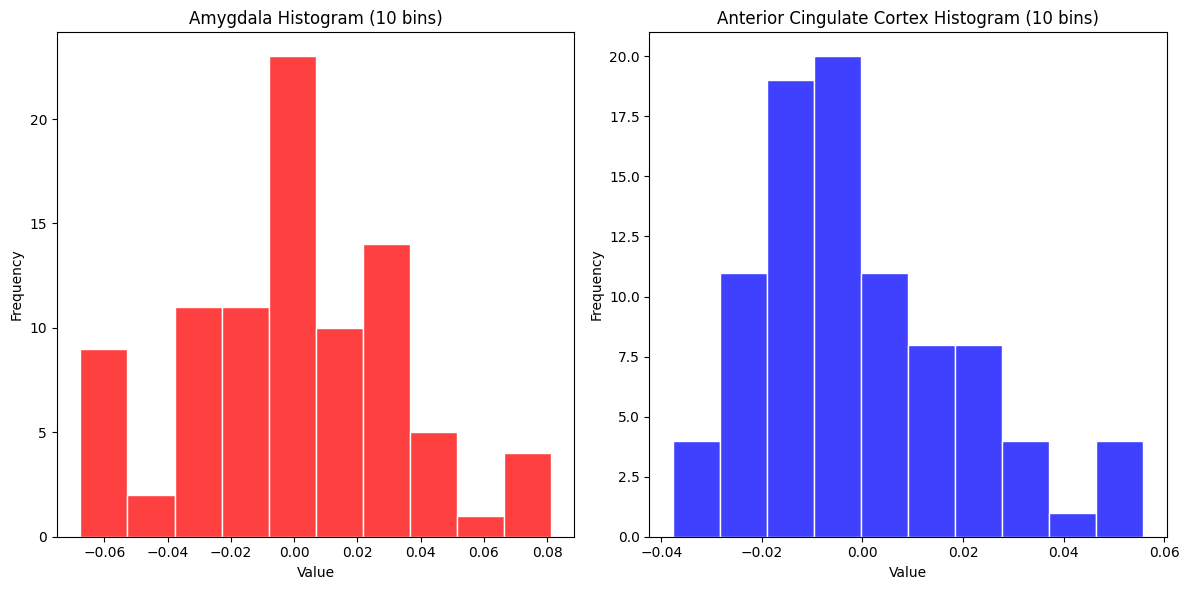

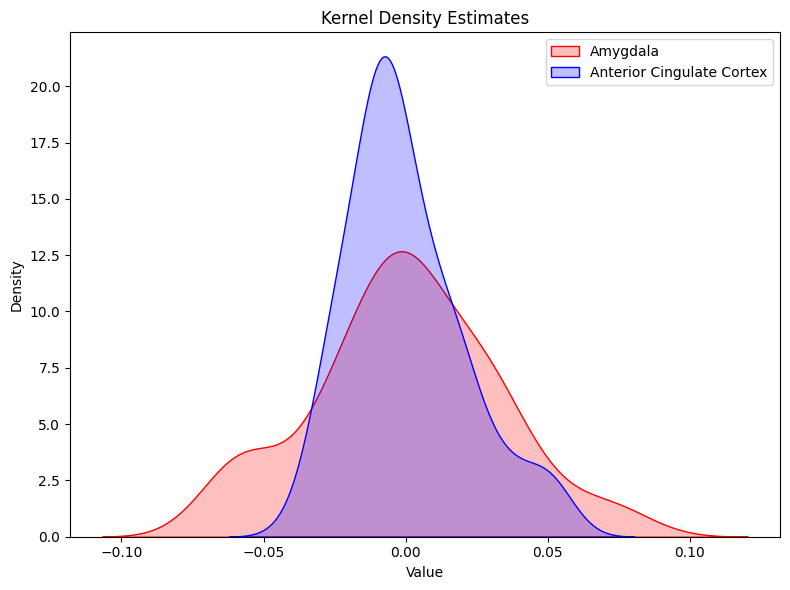

In [15]:
#|echo: false

# part A
def plot_1d_histograms_and_kdes(data1, data2, title1, title2):
    # https://seaborn.pydata.org/tutorial/distributions.html#plotting-univariate-histograms

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

    bins = 10
    sns.histplot(data1, bins = bins, ax = ax1, edgecolor = 'white', color = 'red')
    ax1.set_title(f'{title1} Histogram ({bins} bins)')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    
    sns.histplot(data2, bins = bins, ax = ax2, edgecolor = 'white', color = 'blue')
    ax2.set_title(f'{title2} Histogram ({bins} bins)')
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # https://seaborn.pydata.org/tutorial/distributions.html#kernel-density-estimation
    # https://www.geeksforgeeks.org/kde-plot-visualization-with-pandas-and-seaborn/

    plot = plt.figure(figsize = (8, 6))
    # testing pdf output image size (not working too great - will come back if time permits)
    # plot.set_figwidth(8)
    # plot.set_figheight(6) 

    sns.kdeplot(data1, fill = True, color = 'red', label = title1, bw_method = 0.40)
    sns.kdeplot(data2, fill = True, color = 'blue', label = title2, bw_method = 0.40)

    plt.title('Kernel Density Estimates')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_1d_histograms_and_kdes(data1 = amygdala, title1 = 'Amygdala', 
                            data2 = acc, title2 = 'Anterior Cingulate Cortex')

## 4.B
> **Question:** Form 2-dimensional histogram for the pairs of variables (`amygdala`, `acc`). Decide on a suitable number of bins so you can see the shape of the distribution clearly

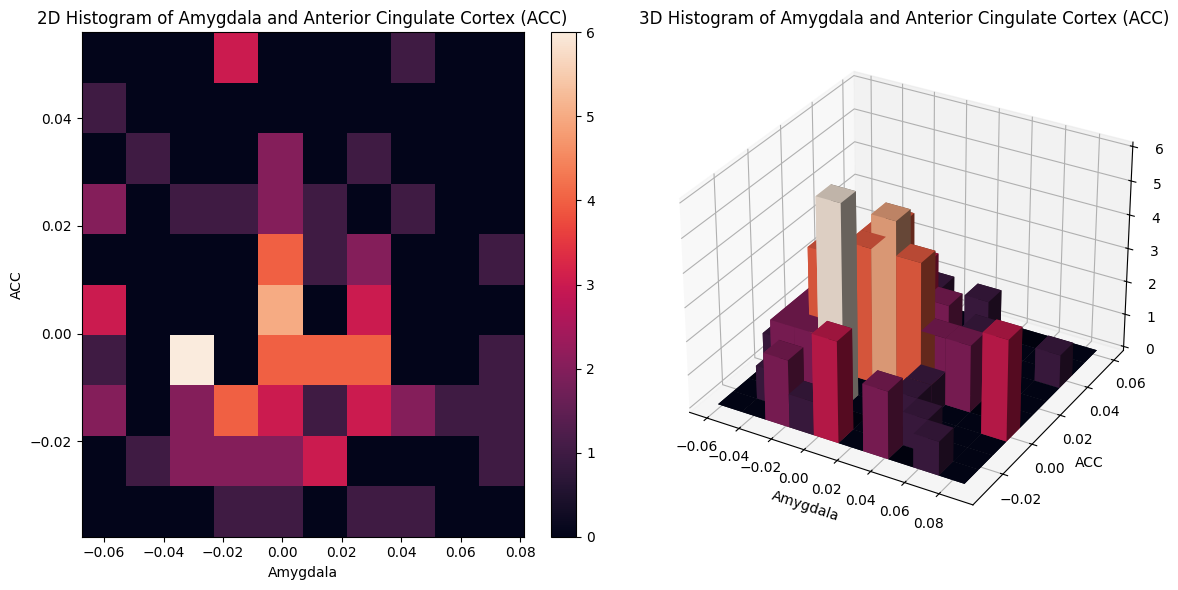

In [16]:
#|echo: false

# part B
def plot_2d_histograms(data1, data2, cmap = None):
    # https://seaborn.pydata.org/tutorial/distributions.html#visualizing-bivariate-distributions
    plt.figure(figsize = (12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(x = data1, y = data2, bins = 10, cmap = cmap, cbar = True, thresh = None)
    plt.title('2D Histogram of Amygdala and Anterior Cingulate Cortex (ACC)')
    plt.xlabel('Amygdala')
    plt.ylabel('ACC')

    ## From Module 6 demo code 
    
    plt.subplot(1, 2, 2, projection = '3d')
    # for 2 dimensional data
    pdata = data_arr[:, :2]
    min_data = pdata.min(0)
    max_data = pdata.max(0)
    nbin = 10 # you can change the number of bins in each dimension
    hist, xedges, yedges = np.histogram2d(pdata[:,0], pdata[:,1], bins=nbin)
    xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])
    xpos = xpos.flatten()/2.
    ypos = ypos.flatten()/2.
    zpos = np.zeros_like (xpos)
    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = hist.flatten()

    # https://matplotlib.org/stable/gallery/color/colormap_reference.html
    cmap = plt.colormaps.get_cmap(cmap)
    colors = cmap(dz/dz.max())

    ax = plt.gca()
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)

    ax.set_title(f'3D Histogram of Amygdala and Anterior Cingulate Cortex (ACC)')
    ax.set_xlabel('Amygdala')
    ax.set_ylabel('ACC')
    
    plt.tight_layout()
    plt.show()

plot_2d_histograms(amygdala, acc, cmap = 'rocket')

## 4.C
> **Question:** Use kernel-density-estimation (KDE) to estimate the 2-dimensional density function of (`amygdala`, `acc`). Set an appropriate kernel bandwidth $h >0$. Please show the two-dimensional KDE (e.g., two-dimensional heat-map, two-dimensional contour plot, etc.) Please explain what you have observed: is the distribution unimodal or bi-modal? Are there any outliers? Are the two variables (`amygdala`, `acc`) likely to be independent or not? Please support your argument with reasonable investigations.

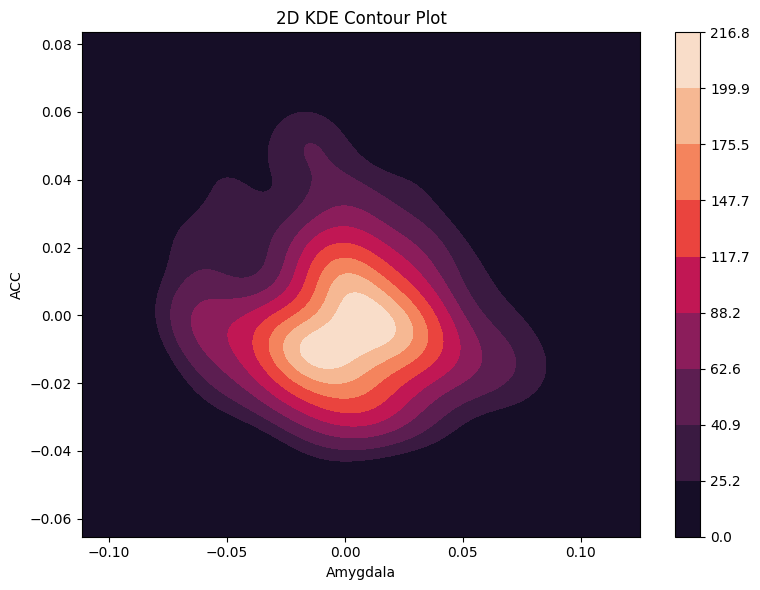

In [17]:
#|echo: false

# Part C

def plot_contour(data1, data2, cmap = None):
    plt.figure(figsize = (8, 6))
    sns.kdeplot(x = data1, y = data2, fill = True, cbar = True, bw_method = 0.45, cmap = cmap, thresh = 0) 
    plt.title('2D KDE Contour Plot')
    plt.xlabel('Amygdala')
    plt.ylabel('ACC')
    plt.tight_layout()
    plt.show()

plot_contour(amygdala, acc, cmap = 'rocket')

As seen from the contour plot above, the data seems to be unimodal since there is only one peak in the distribution. The `bw_method` parameter in sns.kdeplot() is used to set the bandwidth, or the smoothing parameter, of the Gaussian kernel used in the 2D kernel density estimation above. At the current bandwidth of 0.45, there is one peak but a smaller bandwidth results in a more detailed, "peaky" density estimate which produces more peaks. Regardless, I believe that the data is unimodal after seeing the histograms and kde plots. The 2D KDE contour plot also does not indicate the presence of any obvious outliers. The distribution appears to be relatively smooth and continuous without any points or regions that stand out significantly from the overall density pattern.

To test whether the two variables (`amygdala`, `acc`) are independent or not, I carried out a pearson correlation test for independence and a paired sample t-test. 

In [18]:
#|echo: false

r, p_value = stats.pearsonr(amygdala, acc)
print(f"Pearson correlation coefficient: {r:.6f}")
print(f"p-value: {p_value:.4f}")

# https://www.geeksforgeeks.org/how-to-conduct-a-paired-samples-t-test-in-python/
s, p = stats.ttest_rel(amygdala, acc) 
print(f'\nT-test Test statistic: {s:.6f}')
print(f"p-value: {p:.4f}")

Pearson correlation coefficient: -0.128484
p-value: 0.2275

T-test Test statistic: 0.001556
p-value: 0.9988


The pearson correlation coefficient is close to 0 which indicates no linear relationship but the p-value is higher than the common significance level thresholds (e.g., 0.05, 0.01, or 0.001). Therefore, I can't definitively say that the variables are independent from this test. The other test was a t-test where the p-value is much greater than 0.05. This suggests that there is no statistically significant difference between the paired samples (amygdala and ACC). Since the p-value is very high (0.9315), I failed to reject the null hypothesis. Therefore, there is no significant difference between the amygdala and ACC measurements and they could be considered independent. 

Regardless, the results indicate a very small correlation and the plots above suggest a degree of dependence between the two regions. This is expected as different parts of the brain often work together to process information and make decisions which would lead to some level of correlation.

## 4.D

> **Question:**  We will consider the variable `orientation` and consider conditional distributions. Please plot the estimated conditional distribution of `amygdala` conditioning on political `orientation`: $p(\textsf{amygdala}|\textsf{orientation}=c)$, $c = 2, \ldots, 5$, using KDE. Set an appropriate kernel bandwidth $h >0$.  Do the same for the volume of the `acc`: plot $p(\textsf{acc}|\textsf{orientation}=c)$, $c = 2, \ldots, 5$ using KDE. (Note that the conditional distribution can be understood as fitting a distribution for the data with the same `orientation`. Thus you should plot 8 one-dimensional distribution functions in total for this question.) 
> 
> Now please explain based on the results, can you infer that the conditional distribution of `amygdala` and `acc`, respectively, are different from $c = 2, \ldots, 5$? This is a type of scientific question one could infer from the data: Whether or not there is a difference between brain structure and political view. 
> 
> Please also fill out the *conditional sample mean* for the two variables.

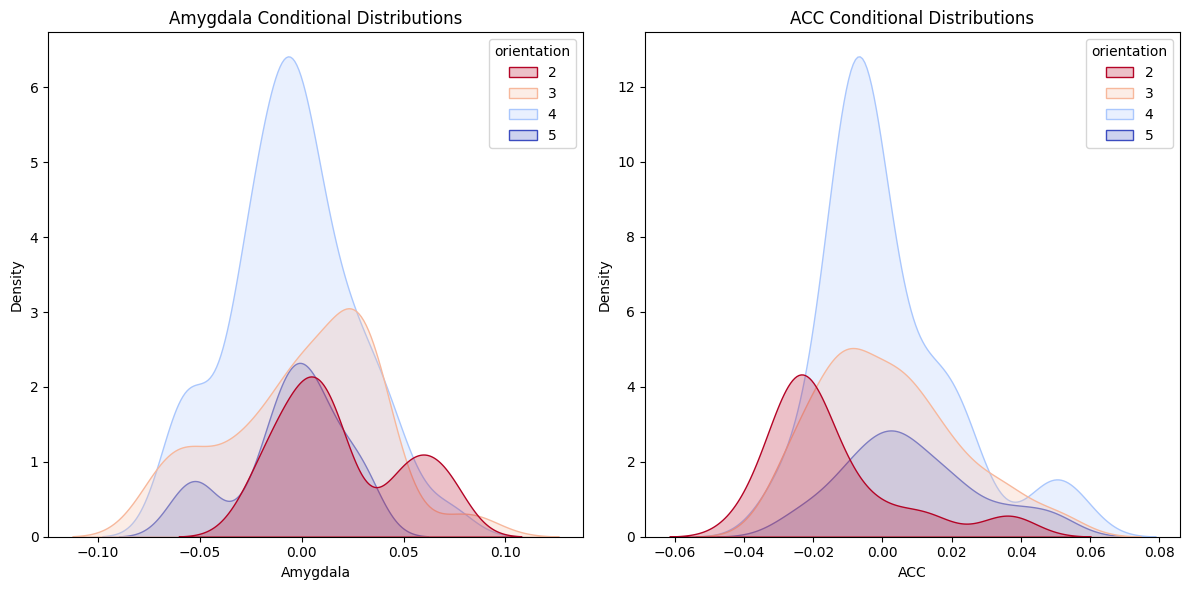

In [19]:
#|echo: false

# Part D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

sns.kdeplot(data = data_df, x = 'amygdala', hue = 'orientation', bw_method = 0.4, 
            fill = True, palette = 'coolwarm_r', ax = ax1)
ax1.set_title('Amygdala Conditional Distributions')
ax1.set_xlabel('Amygdala')

sns.kdeplot(data = data_df, x = 'acc', hue = 'orientation', bw_method = 0.4, 
            fill = True, palette = 'coolwarm_r', ax = ax2)
ax2.set_title('ACC Conditional Distributions')
ax2.set_xlabel('ACC')

plt.tight_layout()
plt.show()

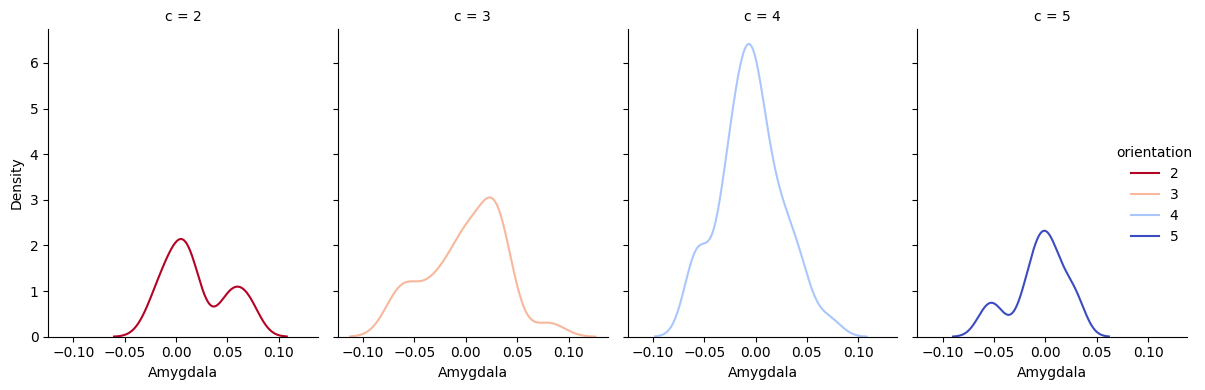

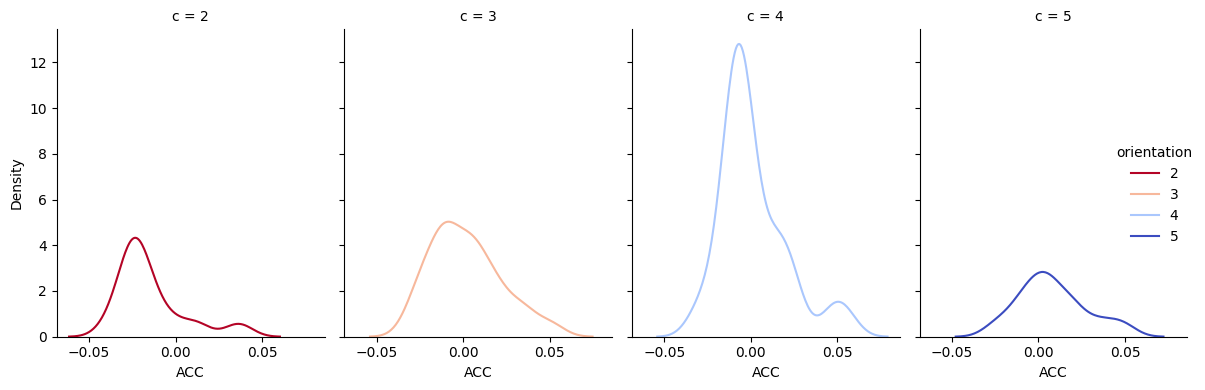

In [20]:
#|echo: false

g = sns.displot(data = data_df, x = "amygdala", hue = "orientation", col = "orientation", bw_method = 0.4,
                kind = "kde", palette = 'coolwarm_r', height = 4, aspect = .7)
g.set_titles("c = {col_name}")
g.set_xlabels('Amygdala')
plt.tight_layout()
plt.show()

g = sns.displot(data = data_df, x = "acc", hue = "orientation", col = "orientation", bw_method = 0.4,
                kind = "kde", palette = 'coolwarm_r', height = 4, aspect = .7)
g.set_titles("c = {col_name}")
g.set_xlabels('ACC')
plt.tight_layout()
plt.show()

In [21]:
#|echo: false

orientations = sorted(data_df['orientation'].unique())

amygdala_means = {}
acc_means = {}

for c in orientations:
    amygdala_c = data_df[data_df['orientation'] == c]['amygdala']
    acc_c = data_df[data_df['orientation'] == c]['acc']
    amygdala_means[c] = amygdala_c.mean()
    acc_means[c] = acc_c.mean()
    
means_df = pd.DataFrame({
    'Orientation': orientations,
    'Amygdala': list(amygdala_means.values()),
    'ACC': list(acc_means.values())
})
means_df = means_df.set_index('Orientation').T
means_df = means_df.style.set_caption("Conditional Sample Means")
display(means_df)

Orientation,2,3,4,5
Amygdala,0.019062,0.000588,-0.004720,-0.005692
ACC,-0.014769,0.001671,0.001310,0.008142


Based on the results, I can infer that the conditional distribution of `amygdala` and `acc` are different for different political orientations. The amygdala distribution for extreme conservative views (c=2) is more spread out and bimodal, indicating greater variability. However, there isn't a clear indication that these individuals have consistently larger or smaller amygdala volumes. For more liberal views(c=4, c=5), the distributions are more centered around zero with c=4 having a notable peak. This suggests that individuals with liberal views might have amygdala volumes closer to the average. Similar to the amygdala, the ACC volumes for extreme conservative views (c=2) show a wider and slightly bimodal distribution, implying greater variability. As views become more liberal, the distributions again become more centralized around zero, particularly for c=4, suggesting ACC volumes closer to the average for these individuals.

Orientation 3 and 4 were the most common which makes sense since most people are not on the extreme ends of the political spectrum. For data points with extreme views (c=2 and c=5), there is skewness in the data as evident by the table of the conditional sample means above. The amygdala values seem to positive for conservatives and negative for liberals, and the ACC values have a large difference between the conservative views (c=2) and the liberal views (c=5). 

Overall, extreme conservative views are associated with a wider range of brain volumes, while liberal views are associated with more consistent, average volumes. However, the data does not clearly indicate that holding a specific political view is associated with having a definitively larger or smaller amygdala or ACC.

## 4.E
> **Question:** Again we will consider the variable `orientation`. We will estimate the conditional *joint* distribution of the volume of the `amygdala` and `acc`, conditioning on  a function of political `orientation`: $p(\textsf{amygdala}, \textsf{acc}|\textsf{orientation}=c)$, $c = 2, \ldots, 5$. You will use two-dimensional KDE to achieve the goal; set an appropriate kernel bandwidth $h >0$. Please show the two-dimensional KDE (e.g., two-dimensional heat-map, two-dimensional contour plot, etc.). 
>
> Please explain based on the results, can you infer that the conditional distribution of two variables (`amygdala`, `acc`) are different from $c = 2, \ldots, 5$? This is a type of scientific question one could infer from the data: Whether or not there is a difference between brain structure and political view.

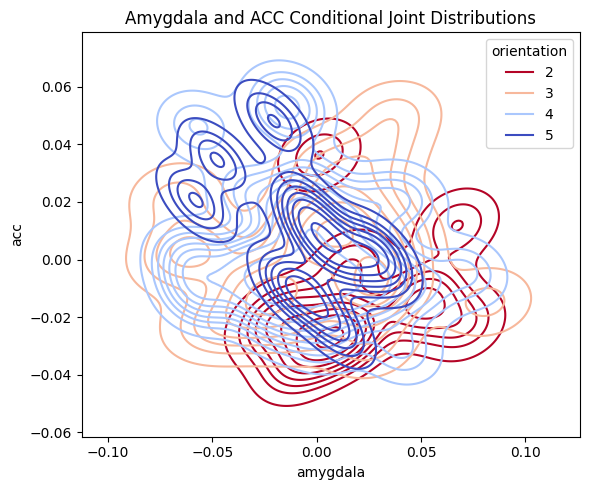

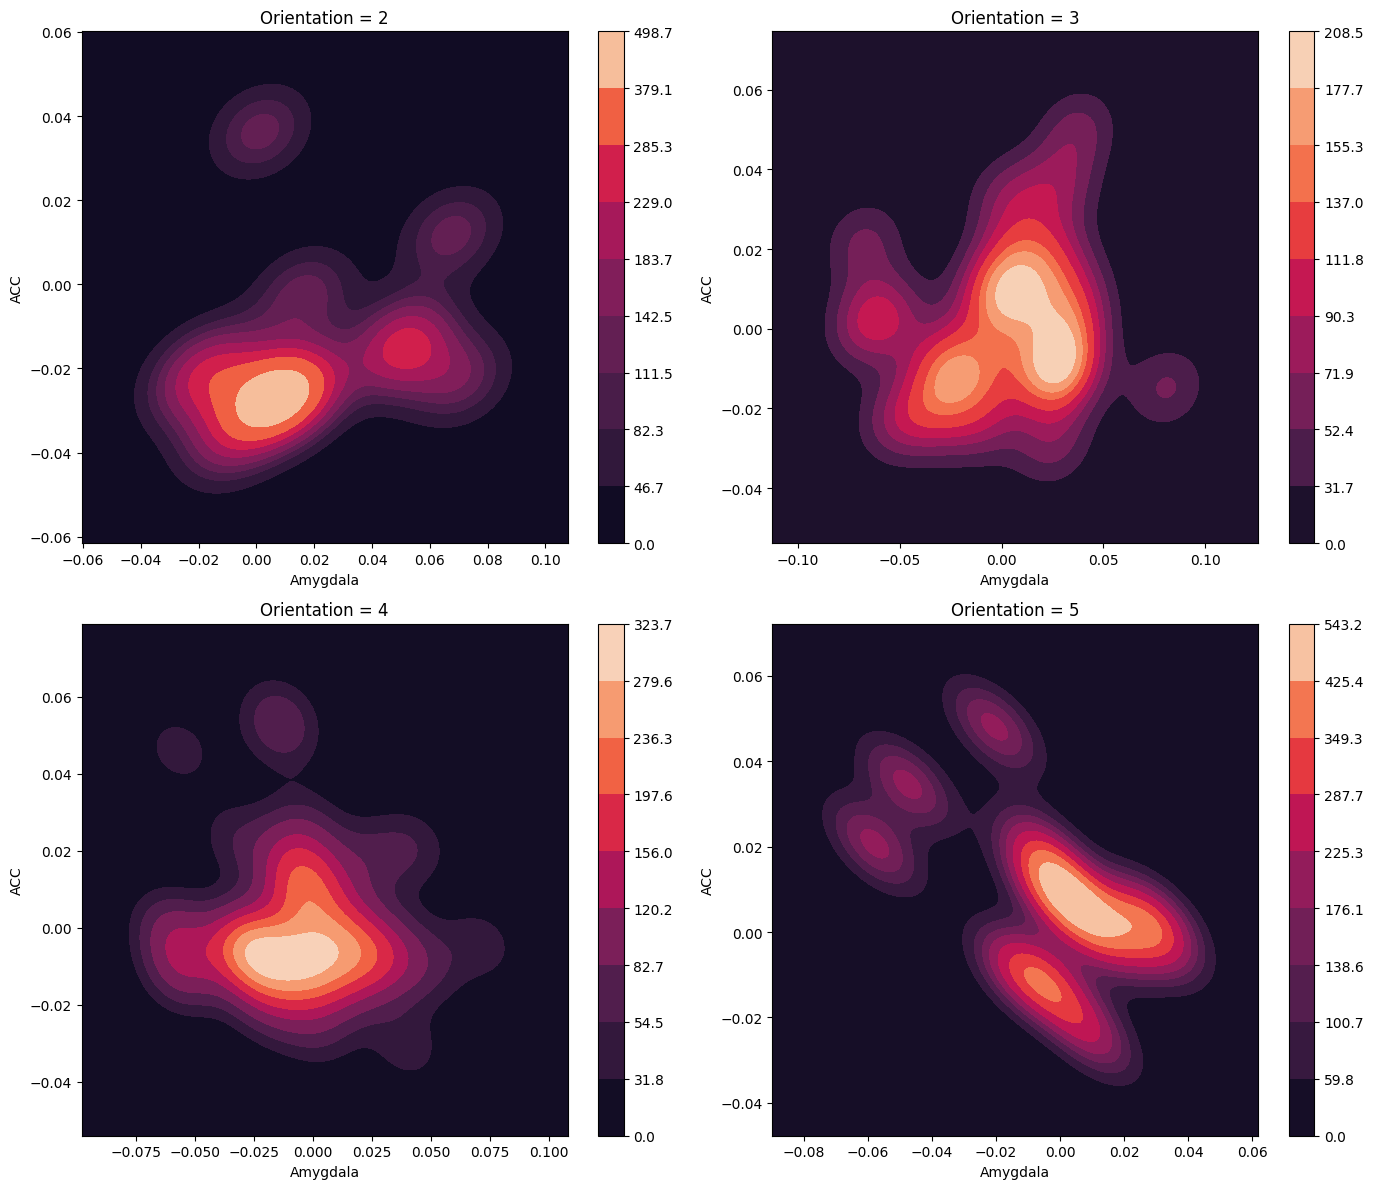

In [22]:
#|echo: false

# Part E
plt.figure(figsize = (6,5))

sns.kdeplot(data = data_df, x = 'amygdala', y = 'acc', hue = 'orientation', bw_method = 0.4, palette = 'coolwarm_r')
plt.title('Amygdala and ACC Conditional Joint Distributions')

plt.tight_layout()
plt.show()

orientations = data_df['orientation'].unique()

fig, axes = plt.subplots(2, 2, figsize = (14, 12))

for i, c in enumerate(sorted(orientations)):
    row = i // 2
    col = i % 2
    
    amygdala_c = data_df[data_df['orientation'] == c]['amygdala']
    acc_c = data_df[data_df['orientation'] == c]['acc']
    
    sns.kdeplot(x = amygdala_c, y = acc_c, fill = True, thresh = 0, cbar = True, cmap = 'rocket', 
                bw_method = 0.4, ax = axes[row, col])
    
    axes[row, col].set_title(f'Orientation = {c}')
    axes[row, col].set_xlabel('Amygdala')
    axes[row, col].set_ylabel('ACC')

plt.tight_layout()
plt.show()

Overall, I can infer that the conditional distributions of the two variables (`amygdala`, `acc`) are different for different political orientations. The contours for different orientations (c = 2, 3, 4, 5) above show distinct shapes and distributions, indicating that the joint distribution of amygdala and ACC volumes changes with political orientation. The plots show varying degrees of spread and clustering based on the political orientation. Conservatives (c = 2) show more variability while liberals (c = 5) display more concentrated and distinct clusters. The distributions for c = 3 and c = 4 are close, but the distributions for the extreme views (c = 2, c = 5) differ greatly in their shape and the regions they occupy on the plot. 

# 5 - Eigenfaces and simple face recognition

This part uses a subset of data from the Yale Face dataset and aims to use PCA for face recognition. The images are downsampled before being used in the PCA algorithm by a factor of 4 to turn them into a lower resolution image. 

First, given a set of images for each person, we generate the eigenface using these images. I treated one picture from the same person as one data point for that person. Note that each image was first vectorized and was originally a matrix. Thus, the data matrix (for each person) is a matrix; each row is a vectorized picture. I found the weight vectors to combine the pictures to extract different "eigenfaces" that correspond to that person's pictures' first few principal components. 

## 5.A

I performed PCA on the Yale face dataset for Subject 1 and Subject 2, respectively, using all the images except for two test images, one for each subject. All of the images in the subset of the dataset are shown below.

In [23]:
#|echo: false

def plot_images(path):
    dir_list = os.listdir(path)
    
    num_cols = 7
    num_rows = 3
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize = (15, 7))
    fig.suptitle(f'Subset of the Yale Face Dataset', fontweight = 'bold')

    for i, file in enumerate(dir_list):
        row = i // num_cols
        col = i % num_cols
        
        img = Image.open(os.path.join(path, file))
        
        axes[row, col].imshow(img, cmap = 'gray')
        axes[row, col].set_title(file)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

def downsample(img, factor):
    #https://stackoverflow.com/questions/48121916/numpy-resize-rescale-image
    width, height = img.size
    width_reduced = width // factor
    height_reduced = height // factor
    img_resized = img.resize((width_reduced, height_reduced))
    return np.asarray(img_resized), width_reduced, height_reduced

def load_data(path):
    subject1_images = []
    subject2_images = []

    dir_list = os.listdir(path)

    for file in dir_list:
        img = Image.open(path + file)
        
        img_resized, W, H = downsample(img, factor = 4) # resize down by factor of 4
        img_resized = np.ndarray.flatten(img_resized) # vectorize
        # print(img.size)
        # print(img_resized.shape)
    
        if 'subject01' in file:
            if 'subject01-test' in file:
                test1 = img_resized
                continue
            subject1_images.append(img_resized)
        else:
            if 'subject02-test' in file:
                test2 = img_resized
                continue
            subject2_images.append(img_resized)
    
    return np.asarray(subject1_images), np.asarray(subject2_images), test1, test2, W, H

def perform_eigenfaces_pca(data, k, W, H, sub_id):
    pca = PCA(n_components = k)
    pca.fit(data)
    dims = pca.components_*-1
    variances = pca.explained_variance_ratio_

    eigenfaces = dims.reshape((-1, H, W))
    
    fig, axes = plt.subplots(1, k, figsize = (12, 2))
    fig.suptitle(f'PCA on Subject {sub_id}', fontweight = 'bold')

    for i, ax in enumerate(axes.flat):
        if i < len(eigenfaces):
            ax.imshow(eigenfaces[i], cmap='gray')
            ax.set_title(f'PC{i+1} ({variances[i]:.2%})')

        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.tight_layout()
    plt.show()

    return dims

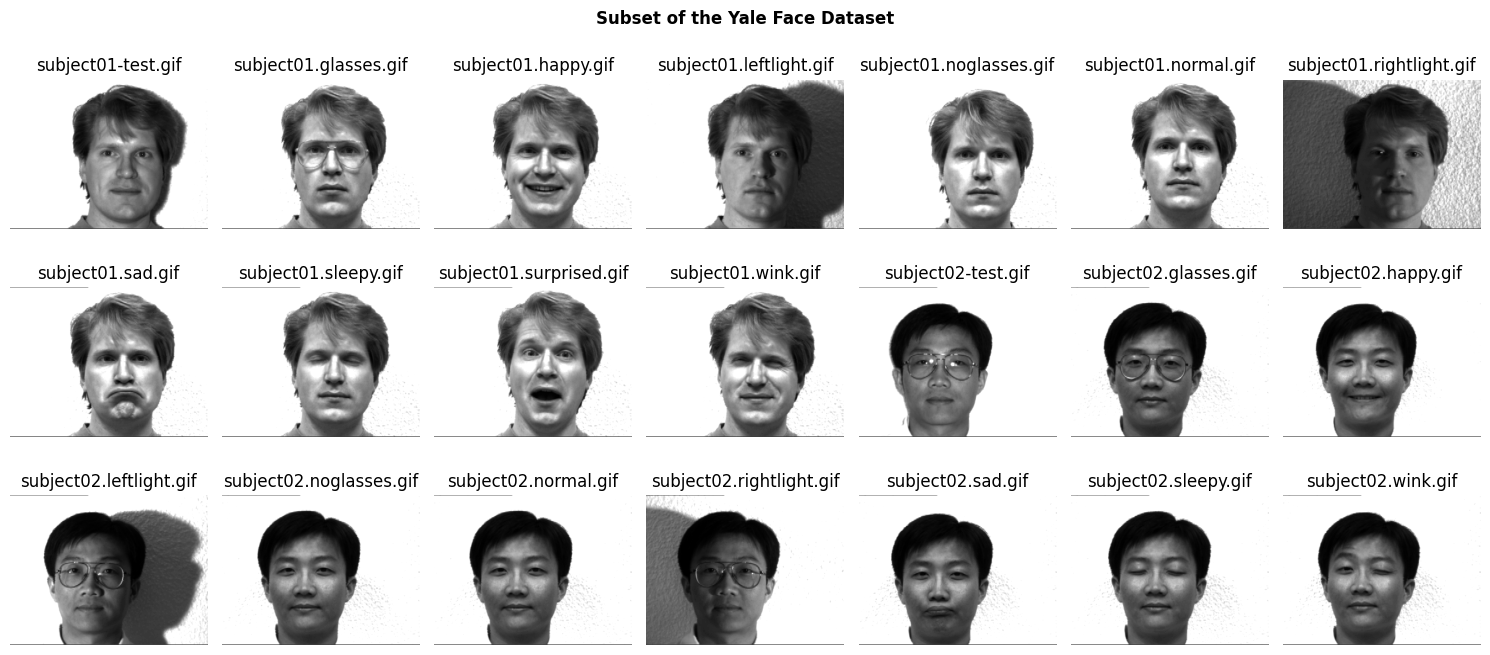

In [24]:
#|echo: false

path = 'data/yalefaces/'
plot_images(path)

After running PCA, I reshaped the eigenvectors into proper images and the first 6 eigenfaces for each subject are shown below.

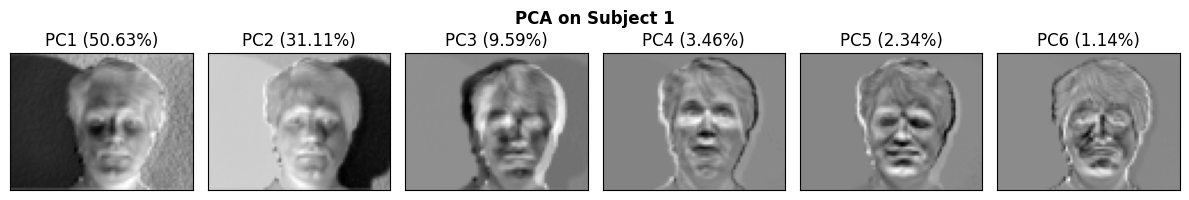

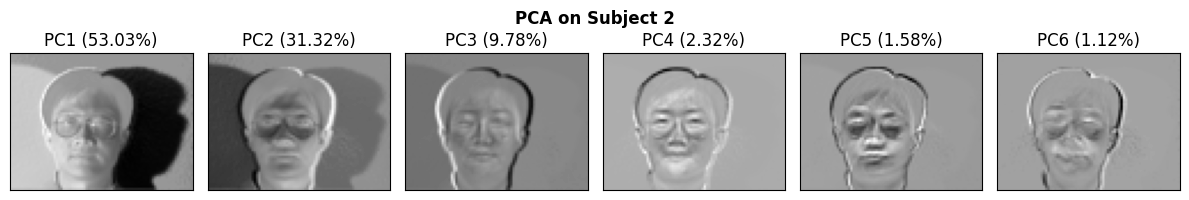

In [25]:
#|echo: false

sub1, sub2, test1, test2, W, H = load_data(path)

sub1_eigenfaces = perform_eigenfaces_pca(sub1, 6, W, H, sub_id = 1)
sub2_eigenfaces = perform_eigenfaces_pca(sub2, 6, W, H, sub_id = 2)

The first principal component (PC1), explaining around 50% of the variance, captures the overall structure of the face the best for both subjects. It captures prominent features like the eyes, nose, and mouth with clear distinction between the face which is the foreground and the background of a plain wall. PC2, accounting for around 30% of the variance, captures the variations in lighting or shading the best as well, particularly around the facial edges. One pattern that I noticed immediately was that the quality of the images showing each subject's face get worse for the latter principal components. Principal components like PC5 and PC6 explain very little variance, only accounting for around 1-2% of the total variance, and therefore resemble faces with features that are hard to make out. A lot of the clarity and facial features that separate humans are gone with each subsequent component, indicating that earlier components capture broader and more significant patterns. 

## 5.B

For this part, I performed a simple face recognition task. Given the test image `subject01-test.gif` and `subject02-test.gif`, I first downsized by a factor of 4 (as before), and vectorized each image. I took the top eigenfaces of Subject 1 and Subject 2, respectively. Then, I calculated the *projection residual* of the 2 vectorized test images with the vectorized eigenfaces:
$$ s_{ij} = \|\textsf{(test image)}_j - \textsf{(eigenface}_i)\textsf{(eigenface})_i^T \textsf{(test image)}_j\|_2^2 $$

All four scores, $s_{ij}$, $i = 1, 2$, $j = 1, 2.$, are reported in the table below. 

In [26]:
#|echo: false

# part b
mu1 = np.mean(sub1, axis = 0)
mu2 = np.mean(sub2, axis = 0)

def projection_residual(test_img, eigenface):
    test_img = test_img.reshape((-1, 1))
    eigenface = eigenface.reshape((-1, 1))

    # print('test_img', test_img.shape)
    # print('eigenface', eigenface.shape)

    # residual = (np.linalg.norm(test_img - (eigenface @ eigenface.T @ test_img)))**2

    inner_math = np.dot(eigenface, np.dot(eigenface.T, test_img))
    residual = (np.linalg.norm(inner_math))**2
    return residual

sub1_top = sub1_eigenfaces[0, :]
sub2_top = sub2_eigenfaces[0, :]

# subtract mean from the test image to center it (feedback from Ed)
data = [
    ['s11', 1, 1, projection_residual((test1-mu1), sub1_top)],
    ['s21', 2, 1, projection_residual((test2-mu2), sub1_top)],
    ['s12', 1, 2, projection_residual((test1-mu1), sub2_top)],
    ['s22', 2, 2, projection_residual((test2-mu2), sub2_top)]
]

df = pd.DataFrame(data, columns = ['Notation', 'Subject ID', 'Test Image ID', 'Projection Residual Score'])
df = df.set_index('Notation').rename_axis('')
df = df.style.set_caption("Projection Residual Scores of Test Images with Eigenfaces")
df = df.format({"Projection Residual Score": "{:,.2f}"})

display(df)

,Subject ID,Test Image ID,Projection Residual Score
,,,
s11,1,1,"124,338.52"
s21,2,1,"272,193.01"
s12,1,2,"1,018,707.54"
s22,2,2,"861,580.77"


Based on the results from the table above, we can see that test image 1 had a lower projection residual score when compared to subject 1's images (s11 < s21), indicating a better match with subject 1 than with subject 2. This is consistent with the prior knowledge that the test image 1 belonged to subject 1. Similarly, test image 2 showed a lower projection residual score against subject 2's images (s22 < s12), confirming that the face recognition algorithm correctly identified test image 2 as belonging to subject 2. This indicates that the algorithm can effectively and accurately classify new images for given subjects.

However, there needs to be a bigger difference in residual scores between test images and different subjects to enhance the algorithm's performance and increase classification confidence. One way to achieve this is by increasing the dataset with more images of each subject which would improve the training of the PCA algorithm. Additionally, rather than relying only on the top principal component, multiple top eigenfaces can be combined to capture more variance within the dataset. This would lead to better representation and differentiation of facial features which might improve classification accuracy. 